## Prepare Data

In [ ]:
%cd dev
from local.torch_basics import *
from local.torch_core import *
from local.data.all import *
from local.test import *
from local.basics import *
from local.callback.all import *
from local.vision.all import *
from local.vision import models

/home/fanyi/environments/fastai_dev/dev


In [ ]:
pascal_source = untar_data(URLs.PASCAL_2007)
images, lbl_bbox = get_annotations(pascal_source/'train.json') 
images1, lbl_bbox1 = get_annotations(pascal_source/'valid.json')
images = images + images1
lbl_bbox = lbl_bbox+lbl_bbox1
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
tst_images = get_image_files(pascal_source/'train')[:50]

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=tst_images,
                 splitter=RandomSplitter(),
                 getters=[noop, lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], n_inp=1)

#partial(get_image_files, pascal_source/"train")

In [ ]:
dbunch = pascal.databunch(pascal_source, item_tfms=Resize(256),batch_tfms=aug_transforms(),bs = 10)

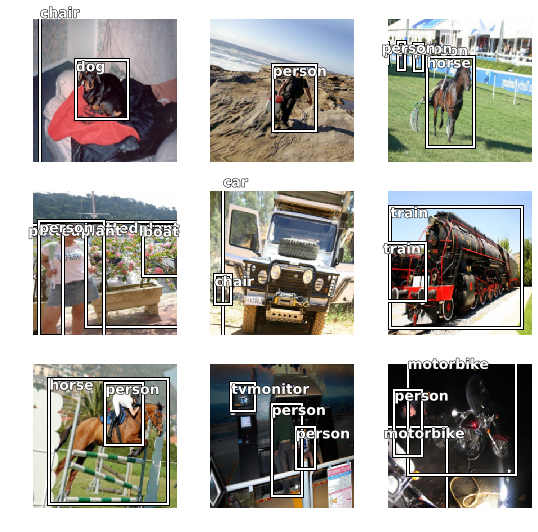

In [ ]:
dbunch.show_batch(max_n=9)

## Anchors, IOU, etc.

In [ ]:
def is_tuple(x): return isinstance(x, tuple)

def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors   

def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    #set_trace()
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def encode_class(idxs, n_classes):
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

## FocalLoss

In [ ]:
class FocalLoss(nn.Module):
    
    def __init__(self, gamma =2., alpha=0.25,  pad_idx=0, scales=None, 
                 ratios=None, reg_loss=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes):
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes, device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx

    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        #set_trace()
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        #set_trace()
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        #set_trace()
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

## SSD MultiHead Model

### Model

In [ ]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, c, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, c*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class SSD_MultiHead(nn.Module):
    def __init__(self, k, c, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, c, 256, bias)
        self.out1 = OutConv(k, c, 256, bias)
        self.out2 = OutConv(k, c, 256, bias)
        self.out3 = OutConv(k, c, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1),[[4,4],[2,2],[1,1]]]

### Learner

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
drop=0.4
k=len(ratios) * len(scales)

In [ ]:
model =  create_body(models.resnet18,pretrained=True)
model.add_module('SSDHead', SSD_MultiHead(k, get_c(dbunch), -4.))
crit = FocalLoss(scales=scales, ratios=ratios)
learn = Learner(dbunch, model, loss_func=crit)

In [ ]:
x, y0, y1 = dbunch.one_batch()
output = model(x)

In [ ]:
y1

tensor([[ 6,  0,  0,  0,  0],
        [10,  0,  0,  0,  0],
        [18, 13, 13,  0,  0],
        [ 5,  0,  0,  0,  0],
        [ 1,  1,  1,  0,  0],
        [12, 12, 13,  0,  0],
        [11, 13, 13, 13, 13],
        [ 7, 13,  0,  0,  0],
        [18, 13, 13,  0,  0],
        [ 3,  0,  0,  0,  0]])

In [ ]:
k

9

In [ ]:
crit(output, y0, y1)

tensor(2.6417, grad_fn=<DivBackward0>)

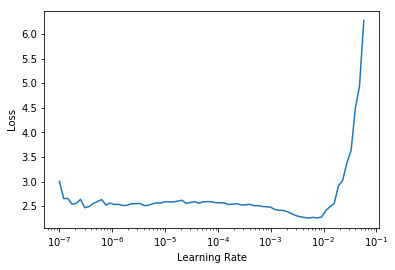

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,2.767233,3.596267,00:53
1,2.359833,2.137894,00:53
2,2.114042,1.607691,00:52
3,1.842703,1.175526,00:53
4,1.602129,1.097446,00:57


In [ ]:
learn.unfreeze()

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.fit_one_cycle(10, 1e-4)

## RetinaNet

### Model

In [ ]:
from local.vision.models.unet import _get_sz_change_idxs

The architecture we will use is a [RetinaNet](https://arxiv.org/abs/1708.02002), which is based on a [Feature Pyramid Network](https://arxiv.org/abs/1612.03144). 

![Retina net](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/retinanet.png?raw=1)

This is a bit like a Unet in the sense we have a branch where the image is progressively reduced then another one where we upsample it again, and there are lateral connections, but we will use the feature maps produced at each level for our final predictions. Specifically, if we start with an image of size (256,256), the traditional resnet has intermediate features maps of sizes:
- C1 (128, 128)  
- C2 (64, 64)
- C3 (32, 32)
- C4 (16, 16)
- C5 (8, 8)
To which the authors add two other features maps C6 and C7 of sizes (4,4) and (2,2) by using stride-2 convolutions. (Note that the model requires an image size of 128 at the minimum because of this.)

Then we have P7 = C7 and we go down from P7 to P2 by upsampling the result of the previous P-layer and adding a lateral connection. The idea is that the last feature map P7 will be responsible to detect big objects, while one like P3 will be responsible to detect smaller objects. 

Each P-something feature map then goes through two subnet of four convolutional layers (with the same weights for all the feature maps), one that will be responsible for finding the category of the object and the other for drawing the bounding box. Each location in the feature map is assigned a given number of anchors (see below) so the classifier ends up with `n_anchors * n_classes` channels and the bounding box regressor with `n_anchors * 4` channels.

In [ ]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = ConvLayer(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [ ]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sz_change_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        self.c5top5 = ConvLayer(sfs_szs[-1][1], chs, ks=1, bias=True)
        self.c5top6 = ConvLayer(sfs_szs[-1][1], chs, stride=2, bias=True)
        self.p6top7 = nn.Sequential(nn.ReLU(), ConvLayer(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([ConvLayer(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [ConvLayer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [ConvLayer(chs, n_classes * n_anchors, bias=True)]
        #layers[-1].bias.data.zero_().add_(final_bias)
        #layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

### Learner

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, get_c(dbunch), final_bias=-4)
crit = FocalLoss(scales=scales, ratios=ratios)
learn = Learner(dbunch, model, loss_func=crit)

In [ ]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
learn.save('/content/gdrive/My Drive/stage1-128', return_path = True)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [ ]:
learn.save('/content/gdrive/My Drive/stage2-128', return_path = True)

In [ ]:
learn.data = get_data(32,192)

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

In [ ]:
learn.save('/content/gdrive/My Drive/stage1-192', return_path = True)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [ ]:
learn.save('/content/gdrive/My Drive/stage2-192', return_path = True)

In [ ]:
learn.data = get_data(24,256)

In [ ]:
learn.freeze()
learn.fit_one_cycle(5, 1e-4)

In [ ]:
learn.save('/content/gdrive/My Drive/stage1-256', return_path = True)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [ ]:
learn.save('/content/gdrive/My Drive/stage2-256', return_path = True)

In [ ]:
learn.load('/content/gdrive/My Drive/stage2-128')

## Darknet but not Yolo3

### Model

In [ ]:
numAnchor=9
numClass =get_c(dbunch)
class DarknetConv2D_BN_Leaky(nn.Module):
    def __init__(self, numIn, numOut, ksize, stride = 1, padding = 1):
        super(DarknetConv2D_BN_Leaky, self).__init__()
        self.conv1 = nn.Conv2d(numIn, numOut, ksize, stride, padding)#regularizer': l2(5e-4)
        self.bn1 = nn.BatchNorm2d(numOut)
        self.leakyReLU = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyReLU(x)
        return x
        
class ResidualBlock(nn.Module):
    def __init__(self, numIn, numOut, numBlock):
        super(ResidualBlock, self).__init__()
        self.numBlock = numBlock
        self.dark_conv1 = DarknetConv2D_BN_Leaky(numIn, numOut, ksize = 3, stride = 2, padding = 1)
        self.dark_conv2 = []
        for i in range(self.numBlock):
            layers = []
            layers.append(DarknetConv2D_BN_Leaky(numOut, numOut//2, ksize = 1, stride = 1, padding = 0))
            layers.append(DarknetConv2D_BN_Leaky(numOut//2, numOut, ksize = 3, stride = 1, padding = 1))
            self.dark_conv2.append(nn.Sequential(*layers))
        self.dark_conv2 = nn.ModuleList(self.dark_conv2)
    def forward(self, x):
        x = self.dark_conv1(x)
        for convblock in self.dark_conv2:
            residual = x
            x = convblock(x)
            x = x + residual
        return x

class LastLayer(nn.Module):
    def __init__(self, numIn, numOut, numOut2):
        super(LastLayer, self).__init__()
        self.dark_conv1 = DarknetConv2D_BN_Leaky(numIn, numOut, ksize = 1, stride = 1, padding = 0)
        self.dark_conv2 = DarknetConv2D_BN_Leaky(numOut, numOut*2, ksize = 3, stride = 1, padding = 1)
        self.dark_conv3 = DarknetConv2D_BN_Leaky(numOut*2, numOut, ksize = 1, stride = 1, padding = 0)
        self.dark_conv4 = DarknetConv2D_BN_Leaky(numOut, numOut*2, ksize = 3, stride = 1, padding = 1)
        self.dark_conv5 = DarknetConv2D_BN_Leaky(numOut*2, numOut, ksize = 1, stride = 1, padding = 0)
        
        self.dark_conv6 = DarknetConv2D_BN_Leaky(numOut, numOut*2, ksize = 3, stride = 1, padding = 1)
        self.conv7 = nn.Conv2d(numOut*2, numOut2, 1, stride = 1, padding = 0)
    
    def forward(self, x):
        x = self.dark_conv1(x)
        x = self.dark_conv2(x)
        x = self.dark_conv3(x)
        x = self.dark_conv4(x)
        x = self.dark_conv5(x)
        
        y = self.dark_conv6(x)
        y = flatten_conv(self.conv7(y),numAnchor)
        return x,y

def flatten_conv(x,numAnchor):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//numAnchor)

class Yolov3(nn.Module):
    def __init__(self, numAnchor, numClass):
        super(Yolov3, self).__init__()
        self.numAnchor, self.numClass = numAnchor, numClass
        self.dark_conv1 = DarknetConv2D_BN_Leaky(3, 32, ksize = 3, stride = 1, padding = 1)
        self.res1 = ResidualBlock(32, 64, 1)
        self.res2 = ResidualBlock(64, 128, 2)
        self.res3 = ResidualBlock(128, 256, 8)
        self.res4 = ResidualBlock(256, 512, 8)
        self.res5 = ResidualBlock(512, 1024, 4)
        
        self.last1 = LastLayer(1024, 512, numAnchor*(numClass+5))
        self.up1 = nn.Sequential(DarknetConv2D_BN_Leaky(512, 256, ksize = 1, stride = 1, padding = 0),
                                 nn.Upsample(scale_factor=2))
        self.last2 = LastLayer(768, 256, numAnchor*(numClass+5))
        self.up2 = nn.Sequential(DarknetConv2D_BN_Leaky(256, 128, ksize = 1, stride = 1, padding = 0),
                                 nn.Upsample(scale_factor=2))
        self.last3 = LastLayer(384, 128, numAnchor*(numClass+5))
        
    def forward(self, x):
        x = self.dark_conv1(x)#32x256x256 
        x = self.res1(x)#64x128x128
        x = self.res2(x)#128x64x64
        x3 = self.res3(x)#256x32x32
        x4 = self.res4(x3)#512x16x16
        x5 = self.res5(x4)#1024x8x8
        
        x,y1 = self.last1(x5)#512x8x8, 
        x = self.up1(x)#256x16x16
        x = torch.cat((x, x4), 1)#768x16x16
        x,y2 = self.last2(x)#256x16x16
        x = self.up2(x)#128x32x32
        x = torch.cat((x, x3), 1)#384x32x32
        x,y3 = self.last3(x)#128x32x32
        out = torch.cat([y1,y2,y3],dim=1)
        return [out[:,:,:(numClass+1)],out[:,:,(numClass+1):],[[8,8],[16,16],[32,32]]]

### Learner

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [ ]:
model = Yolov3(numAnchor,numClass)
crit = FocalLoss(scales=scales, ratios=ratios)
learn = Learner(dbunch, model, loss_func=crit)

In [ ]:
x, y0, y1 = dbunch.one_batch()
output = model(x)

In [ ]:
x.shape, y0.shape, y1.shape

In [ ]:
output[0].shape, output[1].shape, output[2]

In [ ]:
crit(output, y0, y1)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.fit_one_cycle(5, 1e-3)

In [ ]:
learn.recorder.plot_losses()

## Results

In [ ]:
img, bbox_tgt, clas_tgt = next(iter(dbunch.valid_dl))
with torch.no_grad():
    output = learn.model(img)

In [ ]:
learn.loss_func(output, bbox_tgt, clas_tgt)

tensor(2.3948)

In [ ]:
output[0].shape,output[1].shape, output[2]

(torch.Size([20, 189, 21]), torch.Size([20, 189, 4]))

In [ ]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [ ]:
def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
from matplotlib import patches, patheffects
def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
def show_bboxs(img, output, classes=None, ax=None):
    bbox_pred, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
def _draw_outline(o, lw):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])

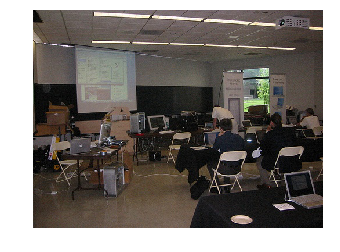

In [ ]:
idx = 5
img = dbunch.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.3, classes=dbunch.vocab)